# Nominal and Ordinal value encoding
In this notebook we'll discuss a couple of examples that relate to the encoding of ordinal and nominal values, and which models react to changes in this encoding. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import seaborn as sns
from typing import Dict, List
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm, trange
from numbers import Number
from sklearn.preprocessing import MinMaxScaler
seed = 42
sns.set()

We can create a small example dataframe that has one column, with the values small, medium and large. These is a so called ordinal value, because there is a clear magnitude order within these values. 

In [2]:
df = pd.DataFrame({'Size': ['small', 'medium', 'large']})
df.Size = df.Size.astype('category')

In [3]:
df.Size.cat.categories = df.Size.cat.reorder_categories(new_categories=['small', 'medium', 'large'])

In [4]:
df.Size.cat.as_ordered()

0     large
1    medium
2     small
Name: Size, dtype: category
Categories (3, object): ['small' < 'medium' < 'large']

In [5]:
print(pd.get_dummies(df.Size))

   small  medium  large
0      0       0      1
1      0       1      0
2      1       0      0


Add the code of the category

In [6]:
df['size_code'] = df.Size.cat.codes
df

,Size,size_code
0,large,2
1,medium,1
2,small,0


# Now for real
This is a dataset about people that might be interested to work for other companies (ethical grey area). 

Regardless, it's a fun dataset with many different `continuous`, `nominal` and `ordinal` data. The target is `binary`.

In [7]:
x_train = pd.read_csv('data/job_interest_data.csv')
y_train = pd.read_csv('data/job_interest_target.csv')
x_test = pd.read_csv('data/X_test.csv')
y_test = pd.read_csv('data/y_test.csv')
df_raw = pd.merge(left=pd.concat([x_train, x_test]), right=pd.concat([y_train, y_test]), on='enrollee_id')
df_raw.target = df_raw.target.astype(int)
df_raw.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,25298,city_138,0.836,Male,No relevent experience,Full time course,High School,NaN,5,100-500,Pvt Ltd,1,45,0
1,4241,city_160,0.920,Male,No relevent experience,Full time course,High School,NaN,5,NaN,NaN,1,17,1
2,24086,city_57,0.866,Male,No relevent experience,no_enrollment,Graduate,STEM,10,NaN,NaN,1,50,0
3,26773,city_16,0.910,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,>4,135,0
4,32325,city_143,0.740,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,17,1


Let's take a look at the datatypes and the number of unique elements. That should give us some insight as to which can be considered nominal values. Whether a nominal values is ordinal depends largely on human interpretation, and is much harder to extract from this information without understanding the semantics of a column. 

In [8]:
pd.concat([df_raw.dtypes, df_raw.nunique()], axis=1)

,0,1
enrollee_id,int64,19158
city,object,123
city_development_index,float64,93
gender,object,3
relevent_experience,object,2
enrolled_university,object,3
education_level,object,5
major_discipline,object,6
experience,object,22
company_size,object,8


We create a list where we keep the resulting scores of the following code pieces. 

A list to which you append dictionaries is a very flexible way of iteratively building up a dataframe. A list with dicts can be cast to a dataframe effortlessly by just doing `pd.DataFrame(list_of_dicts)`. They keys become values and each dictionary should contain one row/sample. 

In [9]:
scores = []

Let's select a subset of columns to reduce the problem a little bit. For the final evaluation, we'll use all columns, but for convenience, let's use this now. 

In [10]:
selection_cols = [
    'relevent_experience',
    'gender',
    'education_level',
    'training_hours',
    'target'
]

df = df_raw[selection_cols]

# Unordered categories

We will start with an unordered encoding of the categorical values. 

In [11]:
cat_cols = ['relevent_experience', 'gender', 'education_level']
df_cat = df.copy()
for col in cat_cols:
    df_cat[col] = df_cat[col].astype('category').cat.codes
df_cat.head()

,relevent_experience,gender,education_level,training_hours,target
0,1,1,1,45,0
1,1,1,1,17,1
2,1,1,0,50,0
3,0,1,0,135,0
4,1,-1,0,17,1


In [12]:
x_train, x_test, y_train, y_test = train_test_split(df_cat.drop('target', axis=1), df_cat.target, random_state=seed)
clf = DecisionTreeClassifier(random_state=seed)
clf.fit(x_train, y_train)

train_acc = clf.score(x_train, y_train)
test_acc = clf.score(x_test, y_test)
print(f'Accuracy train: {train_acc:.3f}')
print(f'Accuracy test: {test_acc:.3f}')
scores.append({'type': 'unordered', 'train_acc': train_acc, 'test_acc': test_acc})

Accuracy train: 0.794
Accuracy test: 0.724


# Ordered categories

In [13]:
cat_cols = ['relevent_experience', 'gender', 'education_level']
df_cat = df.copy()
df_cat.education_level = df_cat.education_level.fillna('Other')
for col in cat_cols:
    df_cat[col] = df_cat[col].astype('category')

new_categories = ['Other', 'Primary School', 'High School', 'Graduate', 'Masters', 'Phd']
df_cat.education_level = df_cat.education_level.cat.reorder_categories(new_categories=new_categories)

for col in cat_cols:
    df_cat[col] = df_cat[col].cat.codes

In [14]:
x_train, x_test, y_train, y_test = train_test_split(df_cat.drop('target', axis=1), df_cat.target, random_state=seed)
clf = DecisionTreeClassifier(random_state=seed)
clf.fit(x_train, y_train)

train_acc = clf.score(x_train, y_train)
test_acc = clf.score(x_test, y_test)
print(f'Accuracy train: {train_acc:.3f}')
print(f'Accuracy test: {test_acc:.3f}')
scores.append({'type': 'ordered', 'train_acc': train_acc, 'test_acc': test_acc})

Accuracy train: 0.794
Accuracy test: 0.724


# One-hot encoding/Dummies

In [15]:
cat_cols = ['relevent_experience', 'gender', 'education_level']
ohe_df = pd.concat([df, pd.get_dummies(df[cat_cols], prefix={x: x for x in cat_cols})], axis=1)
ohe_df = ohe_df.drop(cat_cols, axis=1)
ohe_df.head()

,training_hours,target,relevent_experience_Has relevent experience,relevent_experience_No relevent experience,gender_Female,gender_Male,gender_Other,education_level_Graduate,education_level_High School,education_level_Masters,education_level_Phd,education_level_Primary School
0,45,0,0,1,0,1,0,0,1,0,0,0
1,17,1,0,1,0,1,0,0,1,0,0,0
2,50,0,0,1,0,1,0,1,0,0,0,0
3,135,0,1,0,0,1,0,1,0,0,0,0
4,17,1,0,1,0,0,0,1,0,0,0,0


In [16]:
x_train, x_test, y_train, y_test = train_test_split(ohe_df.drop('target', axis=1), ohe_df.target, random_state=seed)
clf = DecisionTreeClassifier(random_state=seed)
clf.fit(x_train, y_train)

train_acc = clf.score(x_train, y_train)
test_acc = clf.score(x_test, y_test)
print(f'Accuracy train: {train_acc:.3f}')
print(f'Accuracy test: {test_acc:.3f}')
scores.append({'type': 'dummies', 'train_acc': train_acc, 'test_acc': test_acc})

Accuracy train: 0.794
Accuracy test: 0.725


# Scale it up

We'll do the same as what we just did, but we will use all the columns and iteratively limit the models parameters, to see how the overfit-underfit curve impacts how these encodings perform. 

In [17]:
def evaluate_dummies(df: pd.DataFrame, clf: sklearn.base.ClassifierMixin, cat_cols: List, normalize: bool = False):
    prefixes = {x: x for x in cat_cols}
    ohe_df = pd.concat([df, pd.get_dummies(df[cat_cols], prefix=prefixes)], axis=1)
    ohe_df = ohe_df.drop(cat_cols, axis=1)

    x_train, x_test, y_train, y_test = train_test_split(ohe_df.drop('target', axis=1), ohe_df.target, random_state=seed)
    if normalize:
        scaler = MinMaxScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)
    
    clf.fit(x_train, y_train)

    train_acc = clf.score(x_train, y_train)
    test_acc = clf.score(x_test, y_test)
    # print(f'Accuracy train: {train_acc:.3f}')
    # print(f'Accuracy test: {test_acc:.3f}')
    return [
        {
            'mode': str(clf), 
            'eval_data': 'train',
            'type': 'dummies',
            'acc': train_acc,
        },
        {        
            'mode': str(clf), 
            'eval_data': 'test',
            'type': 'dummies',
            'acc': test_acc,
        }
    ]

def evaluate_ordered_category(df: pd.DataFrame, clf: sklearn.base.ClassifierMixin, cat_cols: List, normalize: bool = False):
    df_cat = df.copy()
    df_cat.education_level = df_cat.education_level.fillna('Other')
    for col in cat_cols:
        df_cat[col] = df_cat[col].astype('category')

    new_categories = ['Other', 'Primary School', 'High School', 'Graduate', 'Masters', 'Phd']
    df_cat.education_level = df_cat.education_level.cat.reorder_categories(new_categories=new_categories)

    for col in cat_cols:
        df_cat[col] = df_cat[col].cat.codes

    x_train, x_test, y_train, y_test = train_test_split(df_cat.drop('target', axis=1), df_cat.target, random_state=seed)
    if normalize:
        scaler = MinMaxScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)
    
    clf.fit(x_train, y_train)

    train_acc = clf.score(x_train, y_train)
    test_acc = clf.score(x_test, y_test)
    # print(f'Accuracy train: {train_acc:.3f}')
    # print(f'Accuracy test: {test_acc:.3f}')
    return [
        {
            'mode': str(clf), 
            'eval_data': 'train',
            'type': 'ordered',
            'acc': train_acc,
        },
        {        
            'mode': str(clf), 
            'eval_data': 'test',
            'type': 'ordered',
            'acc': test_acc,
        }
    ]

def evaluate_unordered_category(df, clf, cat_cols, normalize=False):
    df_cat = df.copy()
    for col in cat_cols:
        df_cat[col] = df_cat[col].astype('category').cat.codes
    
    x_train, x_test, y_train, y_test = train_test_split(df_cat.drop('target', axis=1), df_cat.target, random_state=seed)
    if normalize:
        scaler = MinMaxScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)
    
    clf.fit(x_train, y_train)

    train_acc = clf.score(x_train, y_train)
    test_acc = clf.score(x_test, y_test)
    # print(f'Accuracy train: {train_acc:.3f}')
    # print(f'Accuracy test: {test_acc:.3f}')
    return [
        {
            'mode': str(clf), 
            'eval_data': 'train',
            'type': 'unordered',
            'acc': train_acc,
        },
        {        
            'mode': str(clf), 
            'eval_data': 'test',
            'type': 'unordered',
            'acc': test_acc,
        }
    ]

def test_cat_and_dummies(df: pd.DataFrame, 
        cat_cols: List, 
        model: sklearn.base.ClassifierMixin = DecisionTreeClassifier(random_state=seed), 
        normalize: bool = False
    ) -> List:
    scores = []
    scores += evaluate_dummies(df, clf=model, cat_cols=cat_cols, normalize=normalize)
    scores += evaluate_unordered_category(df, clf=model, cat_cols=cat_cols, normalize=normalize)
    scores += evaluate_ordered_category(df, clf=model, cat_cols=cat_cols, normalize=normalize)
    return scores

cat_cols = df_raw.select_dtypes('object').columns.tolist()
scores = test_cat_and_dummies(df_raw, cat_cols=cat_cols, model=DecisionTreeClassifier(random_state=seed, min_samples_leaf=5, max_depth=3))
scores[:2]


[{'mode': 'DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, random_state=42)',
  'eval_data': 'train',
  'type': 'dummies',
  'acc': 0.7802756124721604},
 {'mode': 'DecisionTreeClassifier(max_depth=3, min_samples_leaf=5, random_state=42)',
  'eval_data': 'test',
  'type': 'dummies',
  'acc': 0.7897703549060543}]

In [20]:
def create_comparison_chart(
        df: pd.DataFrame, 
        cat_cols: List, 
        iter_param: str = 'n_neighbors', 
        params: Dict = None, 
        model: sklearn.base.ClassifierMixin = DecisionTreeClassifier, 
        start: Number = 1, 
        end: Number = 20, 
        flip: bool = False, 
        normalize: bool = False
    ):
    params = {} if params is None else params
    scores = []
    stepsize = (end-start) / 10
    for i in tqdm(np.arange(start, end, stepsize)):
        res = test_cat_and_dummies(df, cat_cols=cat_cols, normalize=normalize, model=model(**{iter_param: i}, **params))
        res = [{iter_param: i, **x} for x in res]
        scores.append(res)
    scores = pd.concat([pd.DataFrame(x) for x in scores])

    fig, ax = plt.subplots(figsize=(10, 7))
    ax = sns.lineplot(data=scores, y='acc', x=iter_param, hue='eval_data', markers=True, style='type')
    if flip:
        ax.invert_xaxis()
    return ax

100%|██████████| 10/10 [00:04<00:00,  2.46it/s]


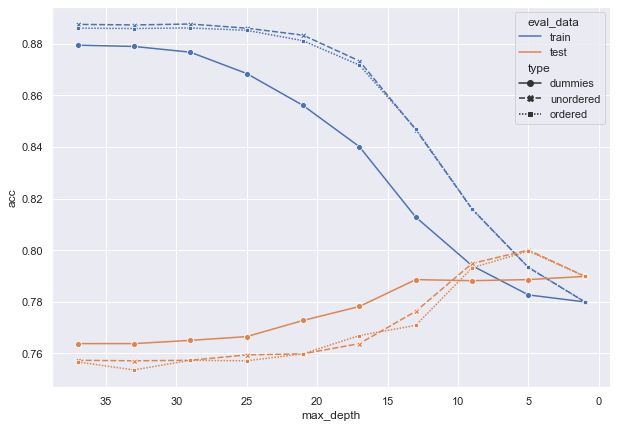

In [21]:
create_comparison_chart(df_raw, cat_cols=cat_cols, iter_param='max_depth', params={'min_samples_leaf': 5}, model=DecisionTreeClassifier, 
    start=1, end=41, flip=True)
plt.savefig('images/decision_tree_dummies_performance_over_max_depth.png', dpi=100)

100%|██████████| 10/10 [02:04<00:00, 12.41s/it]


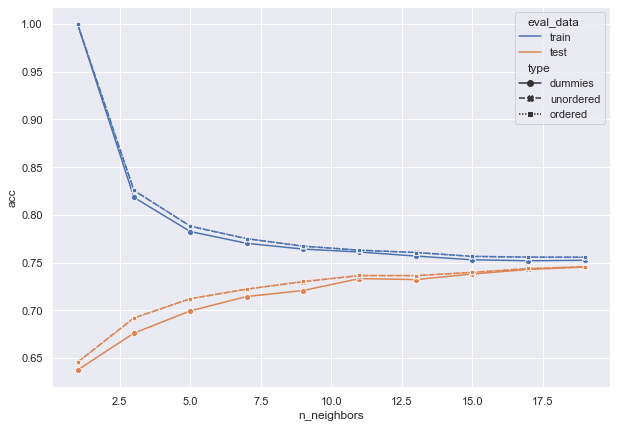

In [382]:
create_comparison_chart(df, cat_cols=cat_cols, iter_param='n_neighbors', params={'n_jobs': -1}, model=KNeighborsClassifier, start=1, end=21, flip=False)
plt.savefig('images/knn_dummies_performance_over_n_neigbors.png', dpi=100)

100%|██████████| 10/10 [00:03<00:00,  2.67it/s]


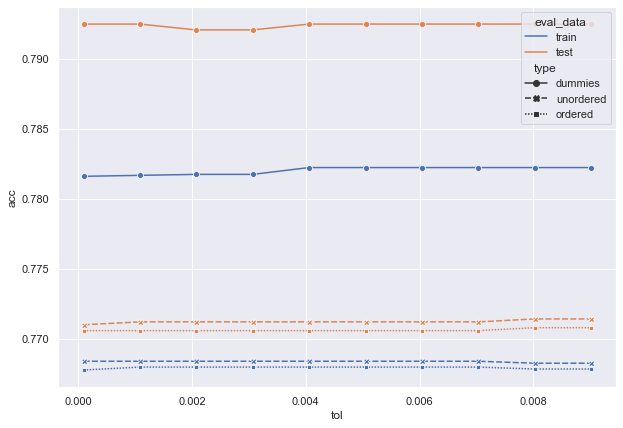

In [414]:
from sklearn.svm import LinearSVC
create_comparison_chart(df, cat_cols=cat_cols, iter_param='tol', params={'random_state': seed, 'dual': False}, 
                        model=LinearSVC, start=1e-4, end=1e-2, flip=False, normalize=True)
plt.savefig('images/svm_dummies_vs_categorical.png', dpi=100)

# Assignment 1
Evaluate a different model, choose a hyperparameter that affects overfit/underfit and plot the results. 

For inspiration, have a look at the Scikit-learn [supervised learning page](https://scikit-learn.org/stable/supervised_learning.html).